In [1]:
import pandas as pd
import numpy as np
import random
import scipy
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

**Задание **

Провести аналогичные исследования но для чека покупок клиентов (колонки `revenue`)  
в интернет магазине есть 2-ва типа продуктов:
* 100 руб.
* 250 руб.

ну и конечно клиент может ничего не купить  
провести исследование изменился ли средний чек

#### определим уровень значимости равный 0.05

 <a id='eda'></a>
### Первичный анализ данных

Прочитаем данные из файла `ab_datas.csv`. Сохраним их в датафрейм `df`. 

Прочитаем данные и посмотрим на первые 5 строк:

In [2]:
df = pd.read_csv('ab_datas.csv')

df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


In [69]:
df.loc[df['user_id'] == 746755]

,user_id,timestamp,group,landing_page,converted,revenue
29073,746755,2017-01-11 01:28:57.083669,control,new_page,1,250
286566,746755,2017-01-05 03:40:08.457451,control,old_page,0,100


In [32]:
df['landing_page'].loc[df['group'] == 'treatment'].loc[df['landing_page'] == 'new_page'].value_counts()

new_page    145311
Name: landing_page, dtype: int64

In [30]:
df['landing_page'].loc[df['group'] == 'control'].value_counts()

old_page    145274
new_page      1928
Name: landing_page, dtype: int64

In [36]:
match_1 = df.query("group == 'treatment' and landing_page == 'old_page'")
match_1.describe()

,user_id,converted,revenue
count,1965.000000,1965.000000,1965.000000
mean,786317.233588,0.127226,116.590331
std,89777.323408,0.333311,103.094076
min,630052.000000,0.000000,0.000000
25%,707554.000000,0.000000,0.000000
50%,784528.000000,0.000000,100.000000
75%,865053.000000,0.000000,250.000000
max,945510.000000,1.000000,250.000000


In [31]:
145311+1965+145274+1928

294478

Посмотрим, сколько посетителей заходио на сайт (количество строк в нашем датафрейме)

In [3]:
#количество посетителей всего

n_rows = df.shape[0]
print("Число строк: {}".format(n_rows))

Число строк: 294478


Сколько уникальных пользователей (уникальных `user_id`) в датасете?

In [4]:
user_total = df.nunique()['user_id']
print("Число уникальных пользователей : {}".format(user_total))

Число уникальных пользователей : 290584


Посетителей из контрольной `control` группы должны были направлять на страницу в старом дизайне  `old_page` , пользователей из тестовой группы `treatment` - на страницу в новом дизайне `new_page`. Проверим, были ли ошибки при направлении.

In [5]:
mismatch_1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print("Из тестовой группы неверно направлены {}".format(len(mismatch_1)) + " пользователей")

mismatch_2 = df.query("group == 'control' and landing_page == 'new_page'")
print("Из контрольной группы неверно направлены  {}".format(len(mismatch_2)) + " пользователей")


Из тестовой группы неверно направлены 1965 пользователей
Из контрольной группы неверно направлены  1928 пользователей


Выясним, есть ли в данных пропуски.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
 5   revenue       294478 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 13.5+ MB


Из сообщений следует, что пропущенных значений нет.

Конверсия по всем посетителям

In [7]:
p_all=df['converted'].mean()
print("Конверсия по всем посетителям: {} %".format(p_all*100))

Конверсия по всем посетителям: 11.96591935560551 %


In [8]:
# можно и так:
sum(df['converted'].values)/n_rows

0.11965919355605512

Давайте посмотрим на описательную статистику нашего датасета (воспользуемся функцией  `describe`) и постараемся получить ответы на следующие вопросы:

- Какова вероятность клика для посетителей из контрольной группы (старый дизайн)?

- Какова вероятность клика для посетителей из тестовой группы (новый дизайн кнопки)?

- Каково соотношение размеров тестовой и контрольный групп? Какова вероятность, что очередной посетитель будет направлен на версию со старым дизайном? С новым дизайном?

In [9]:
df_grp = df.groupby('group')
df_grp.describe()

user_id                                                   \
              count           mean           std       min       25%   
group                                                                  
control    147202.0  788123.098035  91278.896888  630002.0  709287.0   
treatment  147276.0  787825.226283  91142.800641  630000.0  708729.5   

                                         converted            ...            \
                50%        75%       max     count      mean  ...  75%  max   
group                                                         ...             
control    788053.5  867155.50  945998.0  147202.0  0.120399  ...  0.0  1.0   
treatment  787837.5  866693.75  945999.0  147276.0  0.118920  ...  0.0  1.0   

            revenue                                                         
              count        mean         std  min  25%    50%    75%    max  
group                                                                       
control    147202.0   87.431896  102.424926  0.0  0.0    0.0  250.0  250.0  
treatment  147276.0  116.496238  102.732069  0.0  0.0  100.0  250.0  250.0  

[2 rows x 24 columns]

In [40]:
df.query("group == 'treatment' and landing_page == 'new_page'")['revenue'].sum()

16928000

In [41]:
df.query("group == 'control' and landing_page == 'old_page'")['revenue'].sum()

12706650

Text(0.5, 0, 'Revenue')

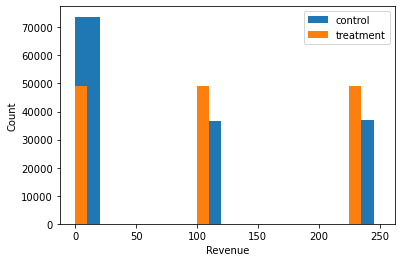

In [52]:
plt.hist(df.loc[df['group']=='control', 'revenue'], width=20)
plt.hist(df.loc[df['group']=='treatment', 'revenue'], width=10)
plt.legend({'control', 'treatment'})
plt.ylabel('Count')
plt.xlabel('Revenue')

Как видим средний чек не изменился(но тут опять же, смотря что понимать под средним чеком, т.к. нет уточнений - средний чек без учета тех, кто ничего не брал или с учетом последних, если брать второй вариант - то средний чек вырос), но количество покупок и общая выручка в тестовой группе выше (без учета ошибочных переводов контрольной группы на новую страницу и наоборот).
Исходя из этого уже можно предположить, что изменения дизайна вносят положительный вклад.

Ответы на остальные вопросы можно найти, например, так:

In [55]:
#объем тестовой группы
n_rows_treat = len(df.query("group == 'treatment' and landing_page == 'new_page'")['revenue'])

#объем контрольной группы
n_rows_contr = len(df.query("group == 'control' and landing_page == 'old_page'")['revenue'])

print("Соотношение размеров тестовой и контрольной групп: {}".format(n_rows_treat/n_rows_contr))

print("Вероятность, что новый пользователь будет направлен на версию со старым дизайном: {}".format(n_rows_treat/n_rows))
print("Вероятность, что новый пользователь будет направлен на версию с новым дизайном: {}".format(n_rows_contr/n_rows))


Соотношение размеров тестовой и контрольной групп: 1.0002546911353718
Вероятность, что новый пользователь будет направлен на версию со старым дизайном: 0.49345282160297205
Вероятность, что новый пользователь будет направлен на версию с новым дизайном: 0.4933271755445229


<a id='si4'></a>
#### Проведение вычислений. $Z$-критерий.

In [59]:
n_rows_treat, n_rows_contr, revenue_treat, revenue_contr

(145311, 145274, 16928000, 12706650)

In [62]:
convert_treat, convert_contr, n_rows_treat, n_rows_contr

(17514, 17723, 145311, 145274)

In [61]:
#Z-статистика
import statsmodels.api as sm
import statsmodels

convert_contr = sum(df.query("group == 'control'")['converted'])
convert_treat = sum(df.query("group == 'treatment'")['converted'])

z_score, p_value = sm.stats.proportions_ztest([convert_treat, convert_contr], [n_rows_treat, n_rows_contr], 
                                              alternative='larger')

print("Z-статистика={},  p_value={}".format(z_score, p_value))


Z-статистика=-1.213226084696041,  p_value=0.8874783030959361


In [65]:
(df.query("group == 'control' and landing_page == 'old_page'")['revenue']!=0).sum()

72453

In [70]:
#Z-статистика
import statsmodels.api as sm
import statsmodels


revenue_contr = sum(df.query("group == 'control' and landing_page == 'old_page'")['revenue'])
revenue_treat = sum(df.query("group == 'treatment' and landing_page == 'new_page'")['revenue'])

z_score, p_value = sm.stats.proportions_ztest([revenue_treat/n_rows_treat, revenue_contr/n_rows_contr], [n_rows_treat, n_rows_contr], 
                                              alternative='larger')

print("Z-статистика={},  p_value={}".format(z_score, p_value))

Z-статистика=2.0314642274725467,  p_value=0.02110396240586192


Правда, у ченя возникают вопросы о корректности применения в данном случае Z-критерия, учстывая, что в тестовой группе и вовсе можно все привести к категориальному типу данных и вероятность принадлежности к любой из категорий примерно равна.
Или у меня внезапно просто мозги перегрелись... Прошу поправить, если где неправ))

#### Проведение вычислений. $T$-test.

In [79]:
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(df.query("group == 'treatment' and landing_page == 'new_page'")['revenue'].values,
                                                              df.query("group == 'control' and landing_page == 'old_page'")['revenue'].values,
                                                              alternative="larger",
                                                              usevar='unequal')

In [80]:
print("T-статистика={},  p_value={}".format(t_score, p_value))

T-статистика=76.26758637238392,  p_value=0.0


#### Проведение вычислений. $Mann–Whitney$-test.

In [81]:
w_score, p_value = scipy.stats.mannwhitneyu(df.query("group == 'treatment' and landing_page == 'new_page'")['revenue'].values,
                                                              df.query("group == 'control' and landing_page == 'old_page'")['revenue'].values,
                         alternative="greater")

In [82]:
print("W-статистика={},  p_value={}".format(w_score, p_value))

W-статистика=12309559045.0,  p_value=0.0


## bootstrap  
Сделаем стат выводы при помощи bootstrap-а

In [16]:
df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


(array([48538.,     0.,     0.,     0., 48435.,     0.,     0.,     0.,
            0., 48338.]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 <BarContainer object of 10 artists>)

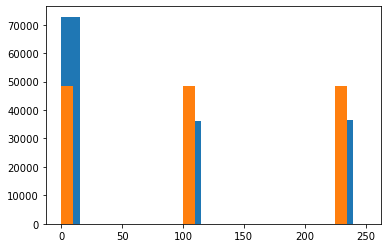

In [86]:
plt.hist(df.query("group == 'control' and landing_page == 'old_page'")['revenue'], width=15)
plt.hist(df.query("group == 'treatment' and landing_page == 'new_page'")['revenue'], width=10)
                                                       

In [87]:
b = df.query("group == 'treatment' and landing_page == 'new_page'")['revenue'].values
a = df.query("group == 'control' and landing_page == 'old_page'")['revenue'].values


In [88]:
b

array([100,   0, 100, ...,   0, 250,   0])

In [89]:
from sklearn.utils import resample

a_means = []
b_means = []

for i in range(10000):
    a_boot = resample(a, replace=True, n_samples=len(a))
    b_boot = resample(b, replace=True, n_samples=len(b))
    
    a_means.append(a_boot.mean())
    b_means.append(b_boot.mean())
    
a_means = np.array(a_means)
b_means = np.array(b_means)

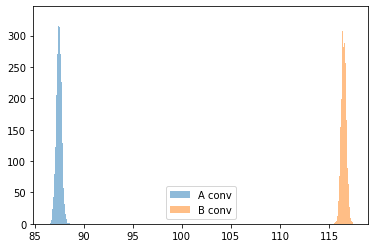

In [90]:
plt.hist(a_means, label='A conv', alpha=0.5, bins=100)
plt.hist(b_means, label='B conv', alpha=0.5, bins=100)

plt.legend()
plt.show()

In [91]:
# доверительный интервал
np.percentile(a_means, 2.5), np.percentile(a_means, 97.5)

(86.94466146729629, 87.9964928342305)

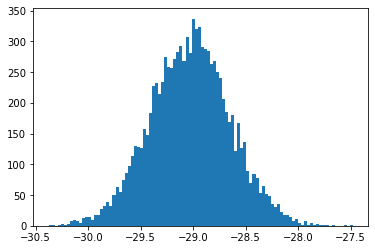

In [92]:
plt.hist(a_means - b_means, bins=100)
plt.show()

In [93]:
# сделаем оценку на p_value
dff = a_means - b_means

len(dff[dff>=0])/len(dff)

0.0

Как видим если брать в средний чек по всем пользователям, включая тех кто ничего не купил, то изменения однозначноо статистически значимы.

In [95]:
treat_group = df.query("group == 'treatment' and landing_page == 'new_page'")
control_group = df.query("group == 'control' and landing_page == 'old_page'")
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(treat_group.loc[treat_group['revenue'] != 0]['revenue'].values,
                                                              control_group.loc[control_group['revenue'] != 0]['revenue'].values,
                                                              alternative="larger",
                                                              usevar='unequal')
print("T-статистика={},  p_value={}".format(t_score, p_value))

T-статистика=-1.2294646144694987,  p_value=0.8905502446345321


In [96]:
w_score, p_value = scipy.stats.mannwhitneyu(treat_group.loc[treat_group['revenue'] != 0]['revenue'].values,
                                                              control_group.loc[control_group['revenue'] != 0]['revenue'].values,
                         alternative="greater")
print("W-статистика={},  p_value={}".format(w_score, p_value))

W-статистика=3495159563.0,  p_value=0.8905504880857265


In [97]:
b = treat_group.loc[treat_group['revenue'] != 0]['revenue'].values
a = control_group.loc[control_group['revenue'] != 0]['revenue'].values
a_means = []
b_means = []

for i in range(10000):
    a_boot = resample(a, replace=True, n_samples=len(a))
    b_boot = resample(b, replace=True, n_samples=len(b))
    
    a_means.append(a_boot.mean())
    b_means.append(b_boot.mean())
    
a_means = np.array(a_means)
b_means = np.array(b_means)

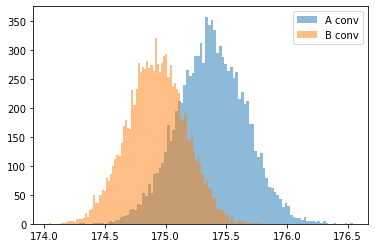

In [98]:
plt.hist(a_means, label='A conv', alpha=0.5, bins=100)
plt.hist(b_means, label='B conv', alpha=0.5, bins=100)

plt.legend()
plt.show()

In [99]:
# доверительный интервал
np.percentile(a_means, 2.5), np.percentile(a_means, 97.5)

(174.8271293114157, 175.92646267235313)

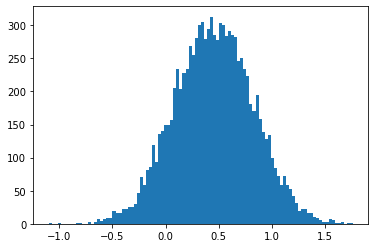

In [100]:
plt.hist(a_means - b_means, bins=100)
plt.show()

In [101]:
# сделаем оценку на p_value
dff = a_means - b_means

len(dff[dff>=0])/len(dff)

0.8881

В случае, если считать средний чек только среди тех, кто что-то купил чтатистические тесты так же подтверждают выводы, полученные эмпирическим путем - мы никак не можем принять альтернативную гипотезу ввиду ее ничтожной статистической значимости, а если точнее - то ее отсутствия.